In [6]:
import sys
%conda install --yes --prefix {sys.prefix} nltk scikit-plot wordcloud openpyxl autopep8

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - nltk
    - openpyxl
    - scikit-plot
    - wordcloud


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    et_xmlfile-1.0.1           |          py_1001          11 KB  conda-forge
    openpyxl-3.0.9             |     pyhd8ed1ab_0         153 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         164 KB

The following NEW packages will be INSTALLED:

  et_xmlfile         conda-forge/noarch::et_xmlfile-1.0.1-py_1001
  openpyxl           conda-forge/noarch::openpyxl-3.0.9-pyhd8ed1ab_0



openpyxl-3.0.9       | 153 KB    | ##################################### | 100% 
et_xmlfile-1.0.1     | 11 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: d

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from scikitplot.metrics import plot_confusion_matrix
from wordcloud import WordCloud
from collections import defaultdict

In [8]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [9]:
initial_df = pd.read_excel("Dataset.xlsx", index_col=None, usecols="A:B")
initial_df

,Column1.data.text,Emotion
0,@RouleLaCookie @luXemusicBX @toda_pisteur Non ...,Dégoût
1,@YarrV @m_nguea Oui cest quand même un gros ra...,Dégoût
2,@salzermorrayOFF @OMjee972 @Diamarc10 @LordDos...,Colère
3,Booba il parle que du père de Vald mais on s'e...,Colère
4,@RGang972 Oui bon sachons raison garder quand ...,INCONNU
...,...,...
964,Finito booba c’est très grave https://t.co/APC...,Dégoût
965,@lilcamscar @nolabuche @vald_ld ça c’est vous ...,Joie
966,@RapAtlas_ Si Booba ne change pas de trottoir,INCONNU
967,Au moins il es premier lui… https://t.co/KZku8...,INCONNU


<AxesSubplot:xlabel='Emotion', ylabel='count'>

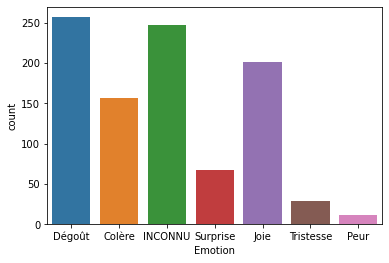

In [10]:
sns.countplot(x=initial_df.Emotion)

In [11]:
cleaned_df = initial_df.replace(to_replace="(@\w+)|(http[a-zA-Z\:\/\.]+)", value ="", regex=True)
# Remove "peur" because the sample size is too small
cleaned_df = cleaned_df.replace(to_replace="Peur", value = "INCONNU")
def custom_encoder(df):
    df = df.replace(to_replace ="Surprise", value =6)
    df = df.replace(to_replace ="Joie", value =5)
    df = df.replace(to_replace ="Dégoût", value =4)
    df = df.replace(to_replace ="Peur", value =3)
    df = df.replace(to_replace ="Colère", value =2)
    df = df.replace(to_replace ="Tristesse", value =1)
    df = df.replace(to_replace ="INCONNU", value =0)
    return df
cleaned_df = custom_encoder(cleaned_df)
# Since we have our own way of tagging, we need to randomize the set
cleaned_df = cleaned_df.sample(frac=1, random_state=1).reset_index(drop=True)

In [12]:
lm = WordNetLemmatizer()
def text_transformation(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('french'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

In [121]:
cv = CountVectorizer(ngram_range=(1,2), strip_accents="ascii")
X_train, X_test, y_train, y_test = train_test_split(cleaned_df['Column1.data.text'], cleaned_df['Emotion'],  test_size=0.3, random_state=1)
X_train = cv.fit_transform(text_transformation(X_train))

In [122]:
word_cloud = ""
for row in text_transformation(cleaned_df['Column1.data.text']):
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 2000, height = 1000,background_color ='white',min_font_size = 15).generate(word_cloud)
file = open("./wordcloud.svg", "w")
file.write(wordcloud.to_svg(embed_font=True, optimize_embedded_font=True))
file.close()

In [49]:
parameters = {'max_features': ('auto','sqrt'),
             'n_estimators': [500, 1000, 1500],
             'max_depth': [5, 10, None],
             'min_samples_split': [5, 10, 15],
             'min_samples_leaf': [1, 2, 5, 10],
             'bootstrap': [True, False]}
grid_search = GridSearchCV(RandomForestClassifier(),parameters,cv=5,return_train_score=True,n_jobs=-1)

In [51]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [5, 10, None],
                         'max_features': ('auto', 'sqrt'),
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [500, 1000, 1500]},
             return_train_score=True)

In [52]:
grid_search.best_score_

0.3362527233115468

In [53]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 1000}

In [ ]:
#Check on 100-entries sample
for i in range(100):
    print('Parameters: ',grid_search.cv_results_['params'][i])
    print('Mean Test Score: ',grid_search.cv_results_['mean_test_score'][i])
    print('Rank: ',grid_search.cv_results_['rank_test_score'][i])

In [116]:
rfc = RandomForestClassifier(max_features=grid_search.best_params_['max_features'],
                                      max_depth=grid_search.best_params_['max_depth'],
                                      n_estimators=grid_search.best_params_['n_estimators'],
                                      min_samples_split=grid_search.best_params_['min_samples_split'],
                                      min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
                                      bootstrap=grid_search.best_params_['bootstrap'])
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=10, n_estimators=1000)

In [123]:
testdata = cv.transform(text_transformation(X_test))
#predict the target
predictions = rfc.predict(testdata)

In [127]:
def custom_decoder(val):
        if (val == 6):
                return "Surprise"
        if (val == 5):
                return "Joie"
        if (val == 4):
                return "Dégoût"
        if (val == 3):
                return "Peur"
        if (val == 2):
                return "Colère"
        if (val == 1):
                return "Tristesse"
        if (val == 0):
                return "INCONNU"
pd.set_option("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None)
pd.DataFrame(data={"Tweet": X_test, "Emotion": map(custom_decoder, predictions)})

,Tweet,Emotion
718,Hum ça mais Booba en classique et ça veut parler inculte … mon pauvre enfant,Joie
637,"De fou, un vrai iencli t'as vu",INCONNU
759,Sayez Booba est finito. Paix à son âme grand rappeur mais fin de carrière après Nero Némésis 0GlxbaIoqm,Dégoût
366,Faut le boycott sérieux,INCONNU
543,J'en reviens pas les storys de vald sur Booba c'est le boss 😭,Joie
41,nan faut aller se faire foutre 2CQOl,Colère
120,"Nn je reflète la réalité de ce qui se passe, booba veut en venir au poings parce qu’il a perdu sur son propre terrain et il pete le seum que vald est eu les couilles de lui répondre et de le finir par la mm occas",Dégoût
725,c’est ce que tu prônes en tt cas que je sache la musique est ouvert a tout le monde 😂 vsy apres jvais peut-être trop loin en dirait,Joie
795,Ch la dinguerie mddrr,INCONNU
672,"ahwai lourd d'être idiot de ne pas aimer le non respect de la vie privée, par exemple",INCONNU
